In [135]:
%%autoreload

UsageError: Cell magic `%%autoreload` not found.


In [136]:
from comet_ml import Experiment

In [137]:
import numpy as np 
import shap
import pickle
import json
import time
import json
import pandas as pd
# import torch
import math
import os
# import torch.nn as nn
# import torch.nn.functional as F
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [138]:
sys.path.append('../ift6758/visualizations/')
import question_7_plots
from question_7_plots import *

In [139]:
import importlib
importlib.reload(question_7_plots)


<module 'question_7_plots' from '/Users/krishnamaneeshad/ift6758/ift6758-project-template-main/notebooks/../ift6758/visualizations/question_7_plots.py'>

In [127]:
df = pd.read_csv('final_df.csv')

In [7]:
df_test = df[df['season'] == 20192020]
df_test_R = df_test[df_test['season_type'] == 'R']
df_test_P = df_test[df_test['season_type'] == 'P']

In [8]:
rf = pickle.load(open("random_forest", 'rb'))
# xgb = pickle.load(open("XGBoost_hmtuning_model_v2.pickle",'rb'))
log1 = pickle.load(open("LogisticRegression_distance", 'rb'))
log2 = pickle.load(open("LogisticRegression_angle", 'rb'))
log3 = pickle.load(open("LogisticRegression_distance+angle", 'rb'))

## Features for RF

In [9]:
old_feat = ['game_id', 'season', 'season_type', 'event_id', 'home_team',
       'away_team', 'home_team_side_1st_period', 'attacking_team',
       'attacking_player', 'goalie', 'period', 'period_time', 'goal_ind',
       'shot_ind', 'x_coordinates', 'y_coordinates', 'shot_type', 'empty_net',
       'strength', 'gwg', 'previous_event_x_coordinates',
       'previous_event_y_coordinates', 'previous_event_period_time',
       'previous_event_type', 'previous_event_period', 'previous_attacking_team',
       'attacking_team_side']

df_feat = df.iloc[:,:60].columns.tolist()

RF_feat = [feat for feat in df_feat if feat not in old_feat]

## Features for XGBoost

In [11]:
feat_xgb = ['game_seconds', 'period', 'x_coordinates', 'y_coordinates',
       'distance_from_net', 'angle_from_net', 'previous_event_type',
       'previous_event_x_coordinates', 'previous_event_y_coordinates',
       'time_since_last_event', 'distance_from_last_event', 'rebound',
       'change_in_angle', 'speed', 'time_since_powerplay_started', '5v5',
       '4v4', '3v3', '5v4', '5v3', '4v3', '4v5', '3v5', '3v4',
       'shot_type_Backhand', 'shot_type_Deflected', 'shot_type_Slap Shot',
       'shot_type_Snap Shot', 'shot_type_Tip-In', 'shot_type_Wrap-around',
       'shot_type_Wrist Shot']

def preprocess(df):
    le = LabelEncoder()
    df["previous_event_type"] = le.fit_transform(df["previous_event_type"])
    
    return df

le_name_mapping = {'Blocked Shot': 0, 'Faceoff': 1, 'Game Official': 2, 'Giveaway': 3, 'Goal': 4, 'Hit': 5, 'Missed Shot': 6, 'Official Challenge': 7, 'Penalty': 8, 'Period End': 9, 'Period Official': 10, 'Period Ready': 11, 'Period Start': 12, 'Shootout Complete': 13, 'Shot': 14, 'Stoppage': 15, 'Takeaway': 16}

## Assign the proper features to each model

In [12]:
X_rf = df_test_R[RF_feat]
X_rf_P = df_test_P[RF_feat]

X_xgb = preprocess(df_test_R[feat_xgb])
X_xgb["previous_event_type"] = X_xgb["previous_event_type"].replace(le_name_mapping)
X_xgb_P = preprocess(df_test_P[feat_xgb])
X_xgb_P["previous_event_type"] = X_xgb_P["previous_event_type"].replace(le_name_mapping)

X_lr_D = df_test_R['distance_from_net'].values.reshape(-1,1)
X_lr_D_P = df_test_P['distance_from_net'].values.reshape(-1,1)

X_lr_A = df_test_R['angle_from_net'].abs().values.reshape(-1,1)
X_lr_A_P = df_test_P['angle_from_net'].abs().values.reshape(-1,1)

X_lr_DA = df_test_R[['distance_from_net','angle_from_net']]
X_lr_DA_P = df_test_P[['distance_from_net','angle_from_net']]

y = df_test_R['goal_ind']
y_P = df_test_P['goal_ind']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Prediction for regular season 

In [20]:
# Random Forest
preds_rf = rf.predict(X_rf)
# XGBoost
# preds_xgb = xgb.predict(X_xgb)
# Logistic regression with Distance
preds_lr_d = log1.predict(X_lr_D)
# Logistic regression with Angle
preds_lr_a = log2.predict(X_lr_A)
# Logistic regression with Distance & Angle (Baseline)
preds_lr_da = log3.predict(X_lr_DA)

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- shot_type_Wrist Shot
Feature names seen at fit time, yet now missing:
- Unnamed: 0

X has feature names, but LogisticRegression was fitted without feature names


In [26]:
# Random Forest
preds_proba_rf = rf.predict_proba(X_rf)
# XGBoost
# preds_proba_xgb = xgb.predict_proba(X_xgb)
# Logistic regression with Distance
preds_proba_lr_d = log1.predict_proba(X_lr_D)
# Logistic regression with Angle
preds_proba_lr_a = log2.predict_proba(X_lr_A)
# Logistic regression with Distance & Angle (Baseline)
preds_proba_lr_da = log3.predict_proba(X_lr_DA)

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- shot_type_Wrist Shot
Feature names seen at fit time, yet now missing:
- Unnamed: 0

X has feature names, but LogisticRegression was fitted without feature names


## Accuracy and ROC for logistic regression models

In [15]:
accuracy_lrd = accuracy_score(y,preds_lr_d)
roc_auc_lrd =  roc_auc_score(y,preds_lr_d)
accuracy_lra = accuracy_score(y,preds_lr_a)
roc_auc_lra =  roc_auc_score(y,preds_lr_a)
accuracy_lrda = accuracy_score(y,preds_lr_da)
roc_auc_lrda =  roc_auc_score(y,preds_lr_da)

## Accuracy and ROC for Random Forest

In [16]:
accuracy_rf = accuracy_score(y,preds_rf)
roc_auc_rf =  roc_auc_score(y,preds_rf)
report_rf = classification_report(y, preds_rf, output_dict=True)

## Accuracy and ROC for XGBoost

In [18]:
# accuracy_xgb = accuracy_score(y,preds_xgb)
# roc_auc_xgb =  roc_auc_score(y,preds_xgb)
# report_xgb = classification_report(y, preds_xgb, output_dict=True)

## Plots for regular season

In [111]:
model_preds_json = [
                        {"y_test": y,
                        "y_pred_proba": preds_proba_lr_a,
                        "label": "Logistic regression with angle"},
                        {"y_test": y,
                        "y_pred_proba": preds_proba_lr_d,
                        "label": "Logistic regression with distance"},
                        {"y_test": y,
                        "y_pred_proba": preds_proba_lr_d,
                        "label": "Logistic regression with distance and angle"},
                    # {"y_test": y,
                    #     "y_pred_proba": preds_proba_xgb,
                    #     "label": "XGBoost"},
                        {"y_test": y,
                        "y_pred_proba": preds_proba_rf,
                        "label": "Random Forest"},
                        ]

In [92]:
y.values

array([1, 0, 0, ..., 0, 1, 0])

In [112]:
# y_test_list = [y.values,y.values,y.values,y.values]
# y_pred_proba_list = [preds_proba_rf[:,1],preds_proba_lr_a[:,1], preds_proba_lr_d[:,1], preds_proba_lr_da[:,1]] #, preds_proba_xgb[:,1]]
# df_prob = pd.DataFrame(list(zip(y_test_list,y_pred_proba_list)), columns = ['goal_ind','Goal_Prob'])
# df_prob['shot_count'] = 1
            

In [113]:
y

332722    1
332723    0
332724    0
332725    0
332726    0
         ..
401593    0
401594    0
401595    0
401596    1
401597    0
Name: goal_ind, Length: 68876, dtype: int64

In [209]:

df_prob = pd.DataFrame({"goal_ind":y, "preds_proba_rf": preds_proba_rf[:,1], "preds_proba_lr_da": preds_proba_lr_da[:,1],"preds_proba_lr_a": preds_proba_lr_a[:,1],"preds_proba_lr_d": preds_proba_lr_d[:,1]}) # "preds_proba_xgb": preds_proba_xgb[:,1] })
df_prob['shot_count'] = 1


In [210]:
df_prob

,goal_ind,preds_proba_rf,preds_proba_lr_da,preds_proba_lr_a,preds_proba_lr_d,shot_count
332722,1,0.395881,0.291350,0.108466,0.158570,1
332723,0,0.384031,0.086100,0.122834,0.059766,1
332724,0,0.398488,0.194873,0.109649,0.106005,1
332725,0,0.269783,0.081444,0.088157,0.089087,1
332726,0,0.296187,0.056044,0.090069,0.061889,1
...,...,...,...,...,...,...
401593,0,0.293730,0.144859,0.110485,0.112274,1
401594,0,0.436604,0.172406,0.117883,0.121688,1
401595,0,0.418098,0.165348,0.122360,0.111295,1
401596,1,0.381805,0.188221,0.116532,0.110950,1


In [211]:
# df_prob.iloc[0, df_prob.columns.get_loc("goal_ind")]

In [212]:
from sklearn.metrics import roc_curve, auc

In [216]:
df_prob.iloc[:,0] #, df_prob.iloc[:,1]

332722    1
332723    0
332724    0
332725    0
332726    0
         ..
401593    0
401594    0
401595    0
401596    1
401597    0
Name: goal_ind, Length: 68876, dtype: int64

In [213]:
type(df_prob["goal_ind"].values[0])

numpy.int64

In [243]:
def roc_auc_plot(name,df_roc,df_auc, question_no = None):
    list_labels = [name,'Random Baseline']
    fig = plt.figure(figsize=(12.5,7.5))
    lw = 3
    color_list = ['darkorange','green','navy','red']
      
    plt.plot(df_roc.FPR[0], df_roc.TPR[0],color=color_list[0],lw=lw,label=f'{list_labels[0]} (area = {round(df_auc.AUC[0],3)})')

    plt.plot([0, 1], [0, 1], color="black", lw=lw, label="Ideal Random Baseline",linestyle="--")
    plt.legend(fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.title("ROC CURVE", fontsize=18)
    plt.yticks(size = 12)
    plt.xticks(size = 12)
# <<<<<<< Updated upstream
    plt.savefig(f'../../ift6758-blog-template-main/figures/milestone2/Q{question_no}_{name}_ROC_Curve.png',bbox_inches = 'tight')
    plt.show()
# =======
    fig.savefig(f'../../ift6758-blog-template-main/figures/milestone2/Q{question_no}'+name+'_ROC_Curve.png',bbox_inches = 'tight')
    return fig

In [251]:
from matplotlib import pyplot as plt
def get_roc_auc_plot(df_prob, name = None):

        """
        structure dataframes before plotting
        Saves a plot for the ROC AUC curve
        """
        # self.infer_model()
        cols = df_prob.columns
        n_models = df_prob.shape[1]
        print(n_models)
        for i in range(n_models-1):
            print(i)
            # feature_list = self.X_train.columns
            fpr_list = []
            tpr_list = []
            roc_auc_list = []
# y_test = y_test.astype(int)

            fpr, tpr, _ = roc_curve(df_prob.iloc[:,0], df_prob.iloc[:,i+1])
            # print(fpr)
            # print("########")
            # print(tpr)

            roc_auc = auc(fpr, tpr)
            fpr_list.append(fpr)
            tpr_list.append(tpr)
            roc_auc_list.append(roc_auc)
            
            #  Call for function to plot roc
            #----------------------------------------------------------------------------------------------- 
        df_roc=pd.DataFrame(list(zip(fpr_list,tpr_list)),columns = ['FPR','TPR'])
        df_auc=pd.DataFrame(list(zip(roc_auc_list)),columns = ['AUC'])
        fig = roc_auc_plot("name",df_roc,df_auc, question_no = question_no)
        return fig

6
0
1
2
3
4


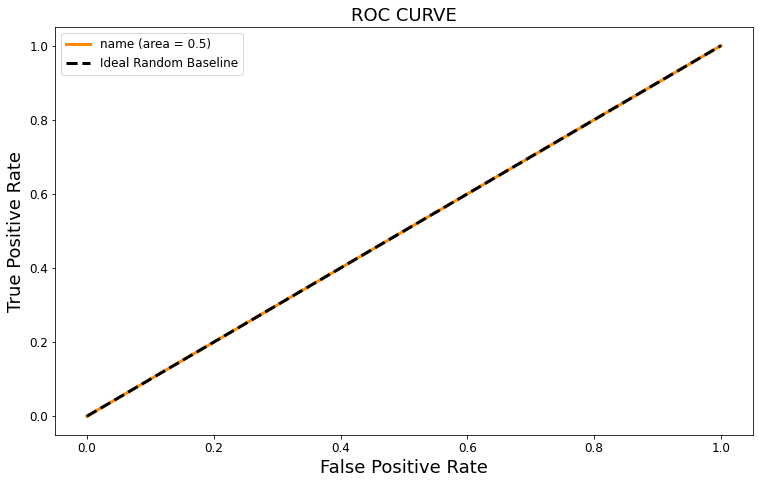

In [252]:
# perf_eval = Performance_Eval(df_prob = df_prob, question_no = question_no)
plt = get_roc_auc_plot(df_prob = df_prob)

new updated version


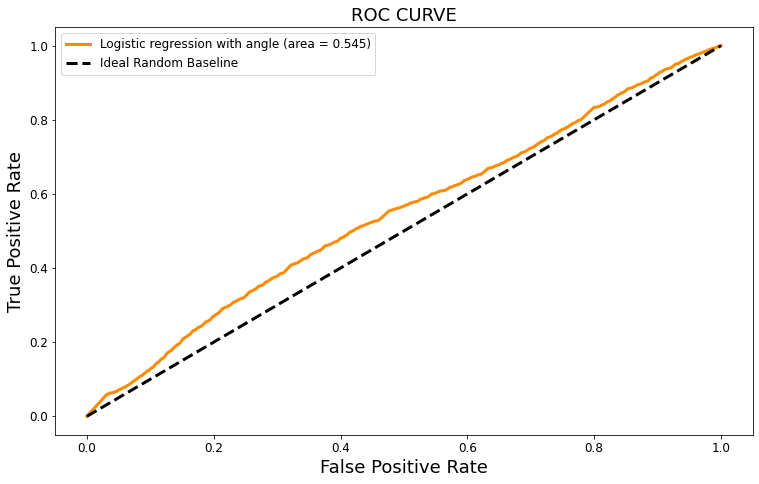

new updated version


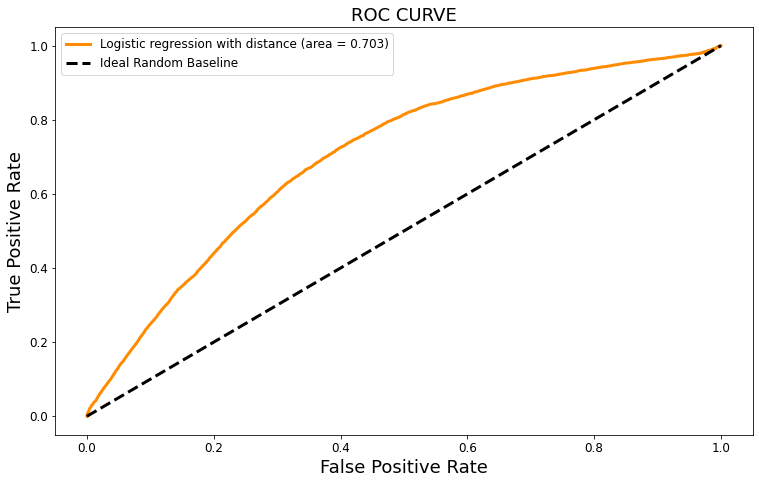

new updated version


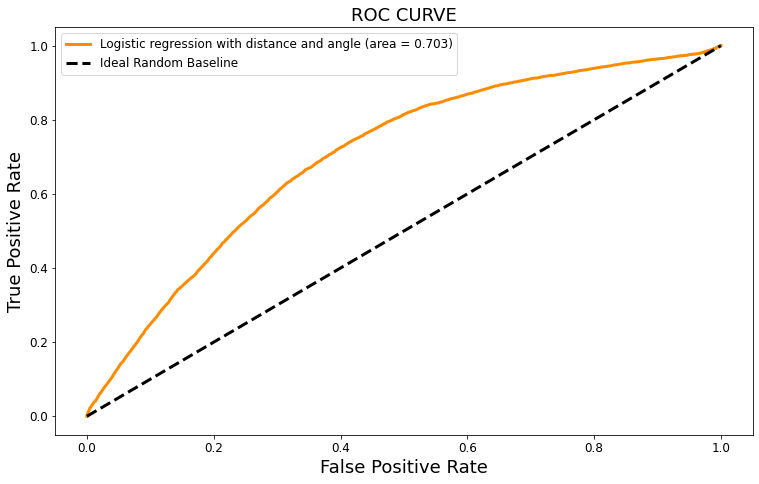

new updated version


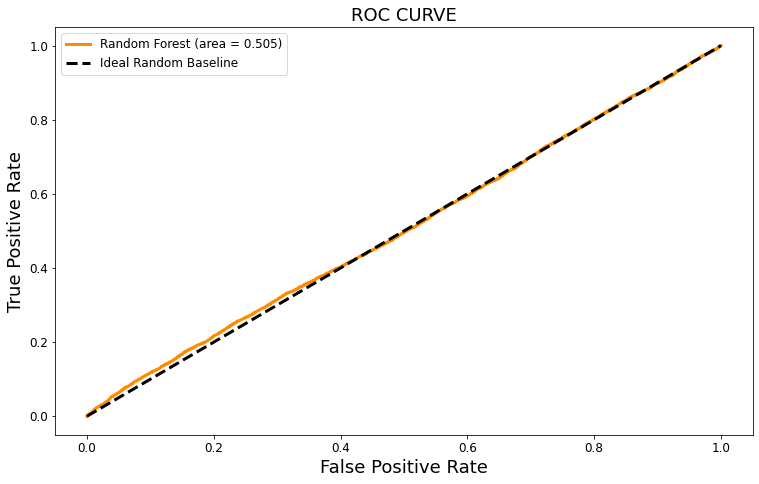

No handles with labels found to put in legend.


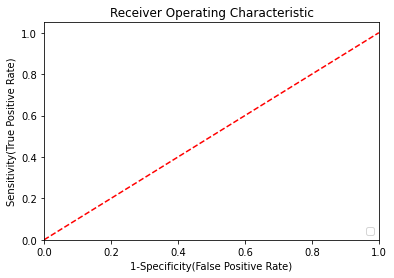

In [81]:
question_no = 7
for model in model_preds_json:
    name = model["label"]
    y_test = model["y_test"]
    y_pred_proba = model["y_pred_proba"][:,1]
    perf_eval = Performance_Eval(y_test = y_test, y_pred_proba = y_pred_proba, question_no = question_no)
    plt = perf_eval.get_roc_auc_plot(name)
    # grp = perf_eval.get_goal_rate_plot(name)
    # crp = perf_eval.get_cum_rate_plot(name)
    # cp = perf_eval.get_calibration_plot(name)

# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   
    
# return fig

In [253]:
# #### USAGE ####
# # model_name_1 = '_XGBoost_Baseline'
# question_no = 7
# for model in model_preds_json:
#     name = model["label"]
#     y_test = model["y_test"]
#     y_pred_proba = model["y_pred_proba"][:,1]
#     perf_eval = Performance_Eval(y_test = y_test, y_pred_proba = y_pred_proba, question_no = question_no)
#     roc = perf_eval.get_roc_auc_plot(name)
#     grp = perf_eval.get_goal_rate_plot(name)
#     crp = perf_eval.get_cum_rate_plot(name)
#     cp = perf_eval.get_calibration_plot(name)

# # Custom settings for the plot 
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('1-Specificity(False Positive Rate)')
# plt.ylabel('Sensitivity(True Positive Rate)')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()   
    
# return fig


## Predictions for playoffs

In [13]:
preds_rf_p = rf.predict(X_rf_P)
preds_xgb_p = xgb.predict(X_xgb_P)
preds_lr_d_p = log1.predict(X_lr_D_P)
preds_lr_a_p = log2.predict(X_lr_A_P)
preds_lr_da_p = log3.predict(X_lr_DA_P)

X has feature names, but LogisticRegression was fitted without feature names


## Accuracy and ROC for logistic regression models - playoffs

In [14]:
accuracy_lrd_p = accuracy_score(y_P,preds_lr_d_p)
roc_auc_lrd_p =  roc_auc_score(y_P,preds_lr_d_p)
accuracy_lra_p = accuracy_score(y_P,preds_lr_a_p)
roc_auc_lra_p =  roc_auc_score(y_P,preds_lr_a_p)
accuracy_lrda_p = accuracy_score(y_P,preds_lr_da_p)
roc_auc_lrda_p =  roc_auc_score(y_P,preds_lr_da_p)

## Accuracy and ROC for Random Forest - playoffs

In [15]:
accuracy_rf_p = accuracy_score(y_P,preds_rf_p)
roc_auc_rf_p =  roc_auc_score(y_P,preds_rf_p)
report_rf_p = classification_report(y_P, preds_rf_p, output_dict=True)

## Accuracy and ROC for XGBoost - playoffs

In [16]:
accuracy_xgb_p = accuracy_score(y_P,preds_xgb_p)
roc_auc_xgb_p =  roc_auc_score(y_P,preds_xgb_p)
report_xgb_p = classification_report(y_P, preds_xgb_p, output_dict=True)

## Plots for playoffs 